In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
from yellowbrick.model_selection import (
    ValidationCurve,
)

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)


X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [2]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [3]:
y_predict = dt.predict(X_test)
tp = (
    (y_test == 1) & (y_test == y_predict)
).sum()  # 123
tn = (
    (y_test == 0) & (y_test == y_predict)
).sum()  # 199
fp = (
    (y_test == 0) & (y_test != y_predict)
).sum()  # 25
fn = (
    (y_test == 1) & (y_test != y_predict)
).sum()  # 46

In [4]:
from sklearn.metrics import confusion_matrix
y_predict = dt.predict(X_test)
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=[
        "Prognoza: zginęli",
        "Prognoza: przeżyli",
    ],
    index=["Wynik prawdziwy: zginęli", "Wynik prawdziwy: przeżyli"],
)

,Prognoza: zginęli,Prognoza: przeżyli
Wynik prawdziwy: zginęli,199,25
Wynik prawdziwy: przeżyli,48,121


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


[Text(0, 0.5, 'Klasa rzeczywista'),
 Text(0.5, 0, 'Klasa prognozowana'),
 Text(0.5, 1.0, 'Tablica pomyłek klasyfikatora drzewa losowego')]

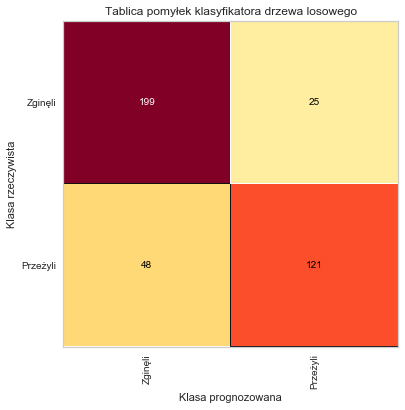

In [5]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import (
    ConfusionMatrix,
)
mapping = {0: "Zginęli", 1: "Przeżyli"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    dt,
    classes=["Zginęli", "Przeżyli"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.ax.set(title="Tablica pomyłek klasyfikatora drzewa losowego", xlabel="Klasa prognozowana", ylabel="Klasa rzeczywista")
#fig.savefig("images/mlpr_1202.png", dpi=300)

In [6]:
(tp + tn) / (tp + tn + fp + fn)

0.8142493638676844

In [7]:
from sklearn.metrics import accuracy_score
y_predict = dt.predict(X_test)
accuracy_score(y_test, y_predict)

0.8142493638676844

In [8]:
tp / (tp + fn)
from sklearn.metrics import recall_score
y_predict = dt.predict(X_test)
recall_score(y_test, y_predict)

0.7159763313609467

In [9]:
tp / (tp + fp)
from sklearn.metrics import precision_score
y_predict = dt.predict(X_test)
precision_score(y_test, y_predict)

0.8287671232876712

In [10]:
pre = tp / (tp + fp)
rec = tp / (tp + fn)
(2 * pre * rec) / (pre + rec)
from sklearn.metrics import f1_score
y_predict = dt.predict(X_test)
f1_score(y_test, y_predict)

0.7682539682539683

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


[Text(0, 0, 'Zginęli'), Text(0, 0, 'Przeżyli')]

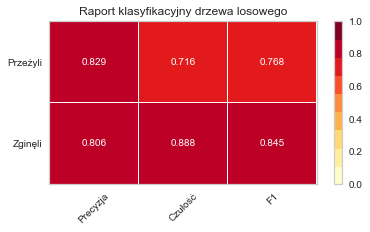

In [11]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import (
    ClassificationReport,
)
fig, ax = plt.subplots(figsize=(6, 3))
cm_viz = ClassificationReport(
    dt,
    classes=["Zginęli", "Przeżyli"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.ax.set(title="Raport klasyfikacyjny drzewa losowego")
xlabels = ("Precyzja", "Czułość", "F1")
ax.set_xticks(np.arange(len(xlabels)) + 0.5)
ax.set_xticklabels(xlabels, rotation=45)
ax.set_yticks(np.arange(len(cm_viz.classes)) + 0.5)
ax.set_yticklabels(cm_viz.classes)
#fig.savefig("images/mlpr_1203.png", dpi=300)

In [12]:
from sklearn.metrics import roc_auc_score
y_predict = dt.predict(X_test)
roc_auc_score(y_test, y_predict)

0.8021845942519018

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


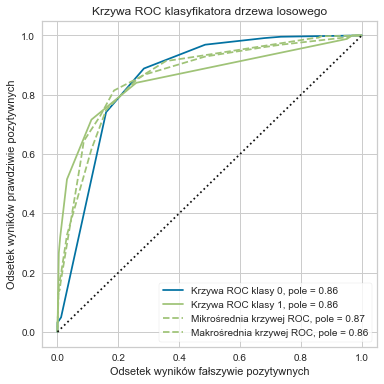

In [21]:
from yellowbrick.classifier import ROCAUC
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(dt)
roc_viz.score(X_test, y_test)
roc_viz.ax.set(title="Krzywa ROC klasyfikatora drzewa losowego",
               xlabel="Odsetek wyników fałszywie pozytywnych",
               ylabel="Odsetek wyników prawdziwie pozytywnych")
ax.legend(("Krzywa ROC klasy {}, pole = {:0.2f}".format(roc_viz.classes_[0], roc_viz.roc_auc[0]),
           "Krzywa ROC klasy {}, pole = {:0.2f}".format(roc_viz.classes_[1], roc_viz.roc_auc[1]),
           "Mikrośrednia krzywej ROC, pole = {:0.2f}".format(roc_viz.roc_auc["micro"]), 
           "Makrośrednia krzywej ROC, pole = {:0.2f}".format(roc_viz.roc_auc["macro"])), 
           frameon=True, loc="lower right")
#fig.savefig("images/mlpr_1204.png", dpi=300)

In [14]:
from sklearn.metrics import (
    average_precision_score,
)
y_predict = dt.predict(X_test)
average_precision_score(y_test, y_predict)

0.7155150490642249

0.8177126373723864


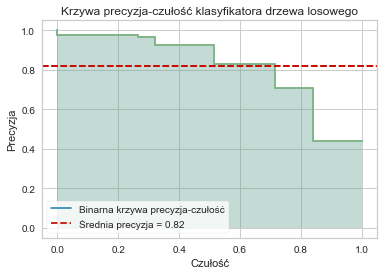

In [15]:
from yellowbrick.classifier import (
    PrecisionRecallCurve,
)
fig, ax = plt.subplots(figsize=(6, 4))
viz = PrecisionRecallCurve(
    DecisionTreeClassifier(max_depth=3)
)
viz.fit(X_train, y_train)
print(viz.score(X_test, y_test))
viz.ax.set(title="Krzywa precyzja-czułość klasyfikatora drzewa losowego",
           xlabel="Czułość",
           ylabel="Precyzja")
ax.legend(("Binarna krzywa precyzja-czułość",
           "Średnia precyzja = {:0.2f}".format(viz.score(X_test, y_test))), 
           frameon=True, loc="lower left")
#fig.savefig("images/mlpr_1205.png", dpi=300)

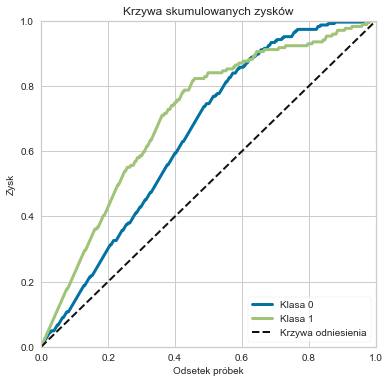

In [16]:
import scikitplot
fig, ax = plt.subplots(figsize=(6, 6))
y_probas = dt.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(
    y_test, y_probas, ax=ax
)
ax.set(title="Krzywa skumulowanych zysków", xlabel="Odsetek próbek", ylabel="Zysk")
ax.legend(("Klasa 0", "Klasa 1", "Krzywa odniesienia"), frameon=True, loc="lower right")
# fig.savefig(
#     "images/mlpr_1206.png",
#     dpi=300,
#     bbox_inches="tight",
# )

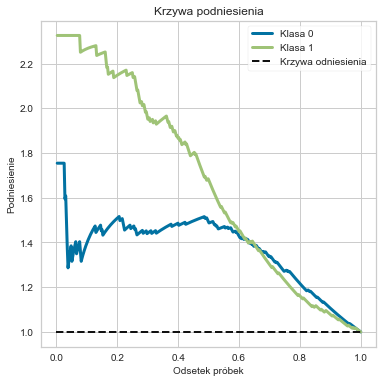

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
y_probas = dt.predict_proba(X_test)
scikitplot.metrics.plot_lift_curve(
    y_test, y_probas, ax=ax
)
ax.set(title="Krzywa podniesienia", xlabel="Odsetek próbek", ylabel="Podniesienie")
ax.legend(("Klasa 0", "Klasa 1", "Krzywa odniesienia"), frameon=True, loc="upper right")
# fig.savefig(
#     "images/mlpr_1207.png",
#     dpi=300,
#     bbox_inches="tight",
# )

[Text(0, 0.5, 'Liczba próbek'),
 Text(0.5, 1.0, 'Równowaga klas dla 393 próbek')]

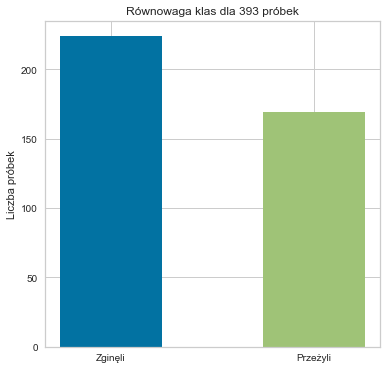

In [18]:
from yellowbrick.classifier import ClassBalance
fig, ax = plt.subplots(figsize=(6, 6))
cb_viz = ClassBalance(
    labels=["Zginęli", "Przeżyli"]
)
cb_viz.fit(y_test)
ax.set_xticks(np.arange(len(cb_viz.labels)))
ax.set_xticklabels(cb_viz.labels)
ax.set(title="Równowaga klas dla {:,} próbek".format(cb_viz.support_.sum()), ylabel="Liczba próbek")
#fig.savefig("images/mlpr_1208.png", dpi=300)

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


[Text(0, 0.5, 'Klasa prognozowana'),
 Text(0.5, 0, 'Klasa rzeczywista'),
 Text(0.5, 1.0, 'Błąd prognozowania klas dla klasyfikatora drzewa losowego')]

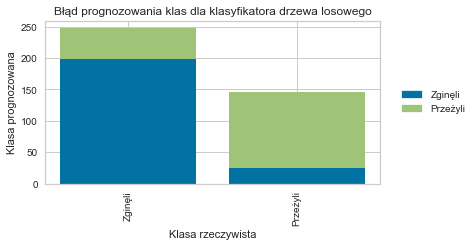

In [19]:
from yellowbrick.classifier import (
    ClassPredictionError,
)
fig, ax = plt.subplots(figsize=(6, 3))
cpe_viz = ClassPredictionError(
    dt, classes=["Zginęli", "Przeżyli"]
)
cpe_viz.score(X_test, y_test)
ax.set_xticks(np.arange(len(cpe_viz.classes)))
ax.set_xticklabels(cpe_viz.classes)
ax.set(title="Błąd prognozowania klas dla klasyfikatora drzewa losowego",
       xlabel="Klasa rzeczywista", ylabel="Klasa prognozowana")
#fig.savefig("images/mlpr_1209.png", dpi=300)

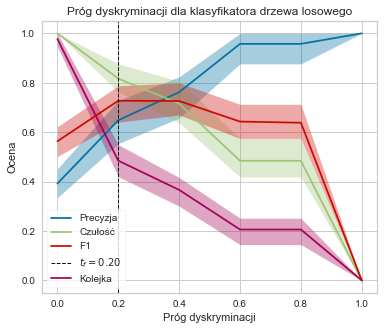

In [20]:
from yellowbrick.classifier import (
    DiscriminationThreshold,
)
fig, ax = plt.subplots(figsize=(6, 5))
dt_viz = DiscriminationThreshold(dt)
dt_viz.fit(X, y)
ax.set(title="Próg dyskryminacji dla klasyfikatora drzewa losowego",
       xlabel="Próg dyskryminacji", ylabel="Ocena")
ax.legend(("Precyzja", "Czułość", "F1", "$t_f={:0.2f}$".format(dt_viz.thresholds_[dt_viz.cv_scores_["fscore"].argmax()]), "Kolejka"), 
           frameon=True, loc="lower left")
#fig.savefig("images/mlpr_1210.png", dpi=300)